In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return beta * torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 10

beta = 0.1

kl_weight = 128/len(trainset)

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + beta * kl_weight * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.40it/s]


Epoch: 0 - TrainRecLoss: 47.57167116665383 - ValidRecLoss: 42.09516438351402
Epoch: 0 - TrainDivLoss: 0.8278713513638324 - ValidDivLoss: 0.9086049863054783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.14it/s]


Epoch: 1 - TrainRecLoss: 40.651912485866916 - ValidRecLoss: 39.089408439925954
Epoch: 1 - TrainDivLoss: 0.9119515820606939 - ValidDivLoss: 0.9510949925531315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.22it/s]


Epoch: 2 - TrainRecLoss: 38.381636353189755 - ValidRecLoss: 37.55901124205771
Epoch: 2 - TrainDivLoss: 0.9892067015806495 - ValidDivLoss: 1.0809539556503296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.50it/s]


Epoch: 3 - TrainRecLoss: 37.08418165747799 - ValidRecLoss: 36.49441236182104
Epoch: 3 - TrainDivLoss: 1.030699892084736 - ValidDivLoss: 0.984645080717304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.41it/s]


Epoch: 4 - TrainRecLoss: 36.222254136986315 - ValidRecLoss: 35.6529018305525
Epoch: 4 - TrainDivLoss: 1.1000833077979748 - ValidDivLoss: 1.1111891692197775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.44it/s]


Epoch: 5 - TrainRecLoss: 35.665133970378555 - ValidRecLoss: 35.030330295804184
Epoch: 5 - TrainDivLoss: 1.1006453741333886 - ValidDivLoss: 1.1520361975778508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.68it/s]


Epoch: 6 - TrainRecLoss: 35.106099622844376 - ValidRecLoss: 34.60436676121965
Epoch: 6 - TrainDivLoss: 1.1541609471794894 - ValidDivLoss: 1.1675170146966283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.80it/s]


Epoch: 7 - TrainRecLoss: 34.72012894799206 - ValidRecLoss: 34.280367742610885
Epoch: 7 - TrainDivLoss: 1.1692574171623442 - ValidDivLoss: 1.190632804285122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.86it/s]


Epoch: 8 - TrainRecLoss: 34.35290454953972 - ValidRecLoss: 34.09451489508906
Epoch: 8 - TrainDivLoss: 1.2110056289985998 - ValidDivLoss: 1.2458829562875289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.63it/s]

Epoch: 9 - TrainRecLoss: 33.98337652129151 - ValidRecLoss: 33.84304247023184
Epoch: 9 - TrainDivLoss: 1.2642076597539091 - ValidDivLoss: 1.3061381186111063


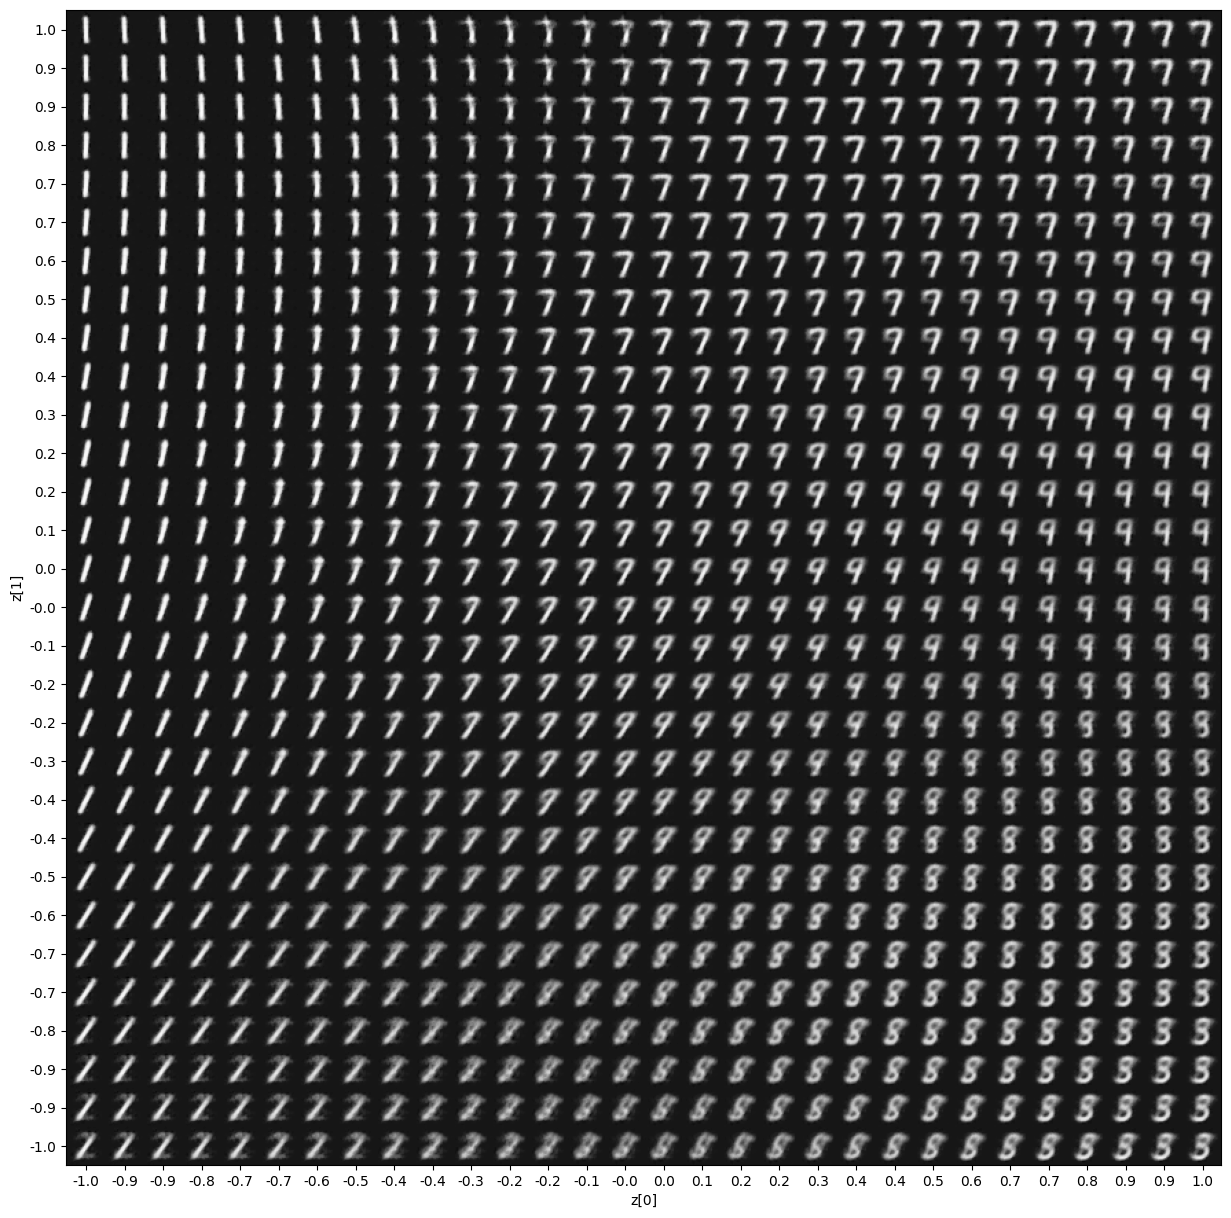

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()